# Dimensionality reduction

###### COMP4670/8600 - Introduction to Statistical Machine Learning - Week 6

Setting up the environment

In this lab, we will use dimensionality reduction techniques to explore a dataset of pictures.

### Assumed knowledge
- Neural net implementation (week 5 lab)
- Autoencoders and PCA (week 6 lectures)

### After this lab, you should be comfortable with:
- Implementing PCA
- Implementing an autoencoder
- Visualising features derived from dimensionality reduction


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as opt
%matplotlib inline

## Load the data

For this lab, we will use a dataset of images of Pokemon sprites.

Load the dataset from the file ``06-dataset.csv`` using ``np.loadtxt``. The datafile represents a 2d array where each row is a 64 by 64 pixel greyscale picture. The entries are floats between 0 and 1, where 0 is white and 1 is black.

Note that while the images are 64 by 64 entries, the dataset you load has rows of size 4096 (which is $64\times 64$) to allow the data to be saved as a 2D array.

In [2]:
dataset = np.loadtxt("06-dataset.csv")

## (Optional) Toy dataset for debugging

For debugging, it is useful to also have a simple dataset that we know is one-dimensional with some noise. You can use this to test your functions produce sensible output.

Write a function that generates data from two Gaussians in $\mathbb{R}^n$ with unit variance, centered at $\mathbf{1}$ and $-\mathbf{1}$ respectively. (Note: $\mathbf{1}$ is the vector $(1, 1, 1, ..., 1)$ in $\mathbb{R}^n$.)

Use the function to generate 100 samples from each Gaussian, with $n=5$.

In [3]:
d=5
n=100
g_one = np.random.standard_normal((100,5)) + 1
g_mone = np.random.standard_normal((100,5)) - 1
print(np.mean(g_one))
print(np.mean(g_mone))

1.0036487106109127
-0.9070655519532322


## Implementing PCA

### Recap on PCA

Remember from lectures that the goal of PCA is to linearly project data points onto a lower dimensional subspace such that the variance of the projected data is maximised. 

Let the data be the set of data points $\{\mathbf{x}_n\}_{n=1}^N$, $\mathbf{x}_n\in\mathbb{R}^d$, with mean $\bar{\mathbf{x}}=\frac{1}{N}\sum_{n=1}^N\mathbf{x}_n$ and covariance matrix $\mathbf{S}=\frac{1}{N}\sum_{n=1}^N(\mathbf{x}_n-\bar{\mathbf{x}})(\mathbf{x}_n-\bar{\mathbf{x}})^T.$

From lectures, we derived that if we are linearly projecting onto a subspace $m<d$, then the $m$ directions to linearly project on are given by the $m$ eigenvactors of $\mathbf{S}$ whose eigenvalues are the $m$ largest, and the variance along each direction is equal to that eigenvalue.

### Using the SVD to implement PCA

Let us assume that $\bar{\mathbf{x}}=\mathbf{0}$. Then $\mathbf{S}=\frac{1}{N}\sum_{n=1}^N\mathbf{x}_n\mathbf{x}_n^T$. 
However, it turns out that
$$\sum_{n=1}^N\mathbf{x}_n\mathbf{x}_n^T=X^TX$$
where $X\in\mathbb{R}^{d\times m}$ is the data matrix.
Thus to find the eigenvalues and vectors of the covariance matrix, we need to find the eigenvalues and vectors of $\frac{1}{N}X^TX$.

It turns out that if the SVD of $X$ is $X=U\Sigma V^T$, then the eigenvectors of $\mathbf{S}$ that correspond to its $k$ largest eigenvalues are the column vectors of $V$ that correspond to the $k$ largest singular values of $X$. **Sorry this was wrong in the previous version, where it had $U$ instead of $V$**.

### Question
Show the left out steps (the two parts where it says "it turns out").

### <span style="color:blue">Answer</span>
<i>--- replace this with your solution, add and remove code and markdown cells as appropriate ---</i>

### Implement PCA
Implement principal component analysis. Your function should take the data matrix and the number of components you wish to calculate and return two matrices:
1. The projection of the data onto the principal components
2. The actual components (eigenvectors) themselves.

Hint: Do not forget to center the data by removing the mean so that you can use the above method. You may find ``np.linalg.svd`` useful.

In [4]:
def PCA(X, d):
    X = X - (np.mean(X, axis=0))
    u,s,vh = np.linalg.svd(X)
    eigvecs = vh.T[:,:d]
    eigvals = s[:d]
    return eigvecs, eigvals


### (Optional) Verifying the calculation with the toy data

Calculate the projection of the toy data onto the first two principal components. Plot the results, with the datapoints coloured according to which Gaussian they were drawn from.

1. Does PCA pick up the two Gaussians?
- What are the eigenvalues associated to these principal components? What do they tell you about how much variance these components explain?

[12.58936449 12.04311659]
[[ 0.09759508  0.27061039]
 [-0.53145718  0.26768771]
 [-0.57362055  0.03004245]
 [-0.12313773 -0.92367845]
 [-0.60317911 -0.03207606]]
[10.79510692 10.49532   ]
[[ 0.16486317  0.84191255]
 [-0.56321086  0.40770652]
 [ 0.17077825  0.14438019]
 [-0.56280356  0.15968008]
 [-0.5565075  -0.28038417]]


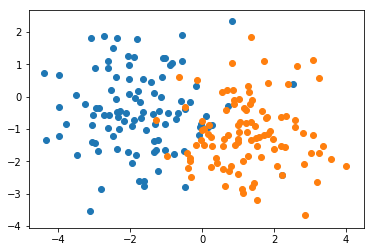

0.5950659096821119

In [5]:
n_pc = 2 #number of principal components

PC_one, eigval_one = PCA(g_one, n_pc)
PC_mone, eigval_mone = PCA(g_mone, n_pc)

print(eigval_one)
print(PC_one)
print(eigval_mone)
print(PC_mone)

proj_one = g_one @ PC_one
proj_mone = g_mone @ PC_mone

plt.figure(1)
plt.scatter(proj_one[:,0], proj_one[:,1])
plt.scatter(proj_mone[:,0], proj_mone[:,1])
plt.show()

np.linalg.norm(PC_one[1])

### <span style="color:blue">Answer</span>

Corresponding eigenvalues to the $n$ Principal Components are the $n$ largest variances.  
This is done to "capture" the dimension of feature with the most spread, to minimize information loss when other features are projected into it.

## Eigen-pokemon

If we perform PCA on a dataset, we expect the principal components to lie in the neighbourhood of our datapoints. In particular, if we do this on a dataset of images, we can interpret the principal components as images.

The following function plots a gallery of images.

In [6]:
# Visualising images
def plot_gallery(images, titles, h, w, n_row=2, n_col=6):
    """Helper function to plot a gallery of portraits.
    Arguments: images: a matrix where each row is an image.
    titles: an array of labels for each image.
    h: the height in pixels of each image.
    w: the width in pixels of each image.
    n_row: the number of rows of images to print.
    n_col: the number of columns of images to print."""
    assert len(images) >= n_row * n_col
    assert len(titles) >= n_row * n_col
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
    plt.show()

Use ``plot_gallery`` to plot the first 30 pokemon images.

(1168, 4096)


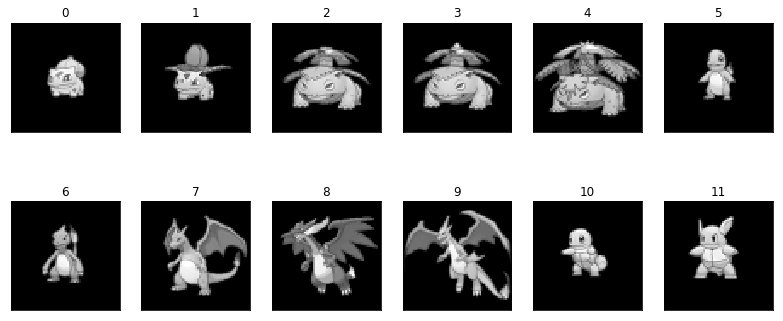

In [7]:
print(dataset.shape)
X = dataset
n = 30

plot_gallery(X[:n,:],
             titles = np.arange(n),
             h = 64,
             w = 64)


Perform PCA on the Pokemon dataset to find the first 200 principal components. Visualise the first 100 using ``plot_gallery``.

### Question

What do you notice about the first few principal components? What are they detecting?
Plot the associated eigenvalues. How can you interpret these?

In [8]:
d = 200
X = dataset

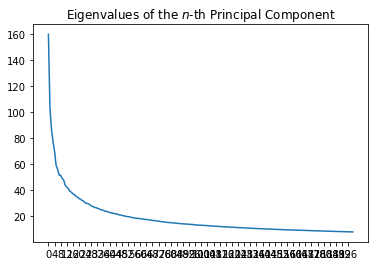

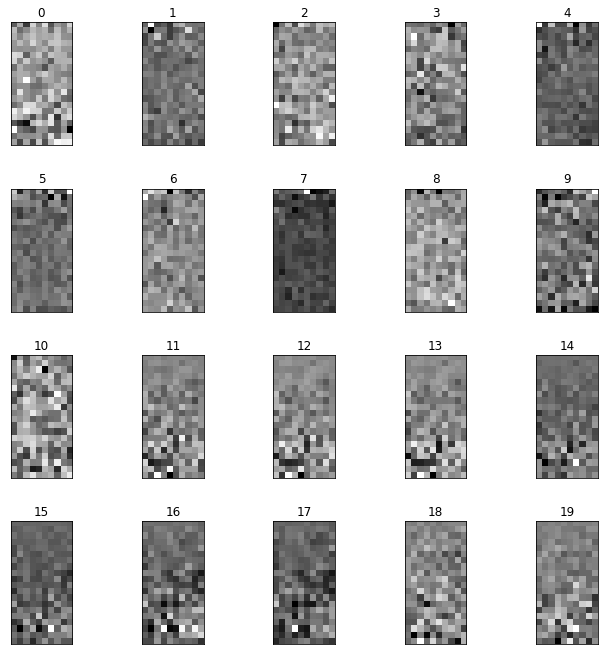

In [9]:
PC, PC_eigval = PCA(X, d)

plt.figure(1)
plt.title("Eigenvalues of the $n$-th Principal Component")
plt.plot(PC_eigval)
plt.xticks(np.arange(len(PC_eigval), step=4))

plot_gallery(PC,
             titles = np.arange(len(PC)),
             h = 20, w = 10,
             n_col = 5, n_row = 4)

### <span style="color:blue">Answer</span>
<i>--- replace this with your solution, add and remove code and markdown cells as appropriate ---</i>

## Reconstructing images using PCA

Plot the reconstructions of the first 30 images using 200 principal components, and using the first 15 principal components. Don't forget to add the mean back in. How good are these reconstructions?

#### Reconstruction:

Reconstructed data $\widetilde{X}$ for data matrix $X \in \mathbb{R}^{N\times D}$ can be calculated by:  
$$\widetilde{X} = ((X-\overline{X})U)U^\top + \overline{X}$$
where $\overline{X} = \begin{bmatrix}\bar{x_1} & \dots & \bar{x_D}\\ \vdots & & \vdots\\ \bar{x_1} & \dots & \bar{x_D}\end{bmatrix}$, and $\bar{x_d}$ is the mean of the $d-th$ feature.


In [20]:
def PCA_compress(X, d, n = len(X)):
    """
    X - feature matrix
    d - number of principal components
    n - number of datapoints compressed, default all rows in X
    """
    X = X[:n,:]
    PC, PC_eigval = PCA(X, d)
    proj_data = ((X @ PC) @ PC.T) + np.mean(X, axis=0)
    return proj_data


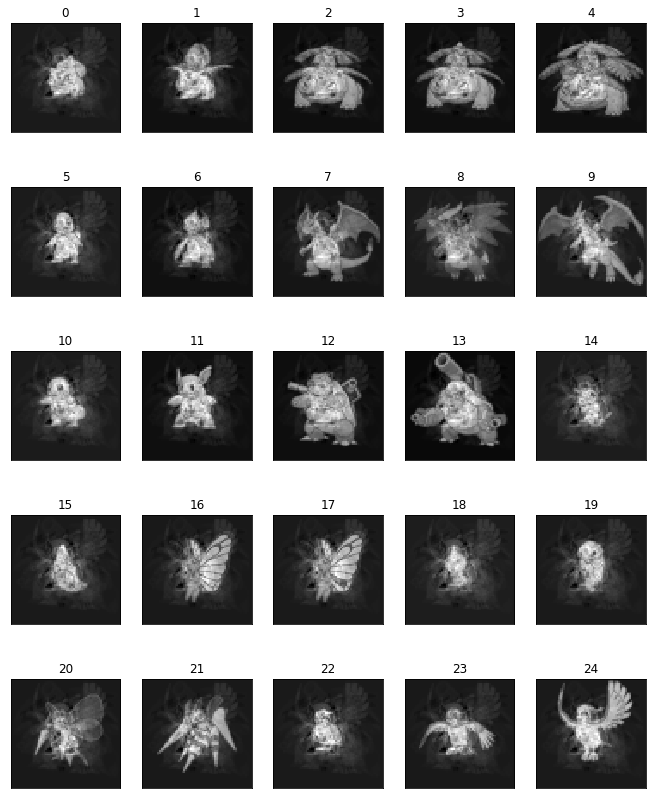

In [21]:
# Compression with 200 principal components
comp_data = PCA_compress(dataset, 200, 30)
plot_gallery(comp_data,
            titles = np.arange(len(comp_data)),
            h = 64, w = 64,
            n_row = 5, n_col = 5)

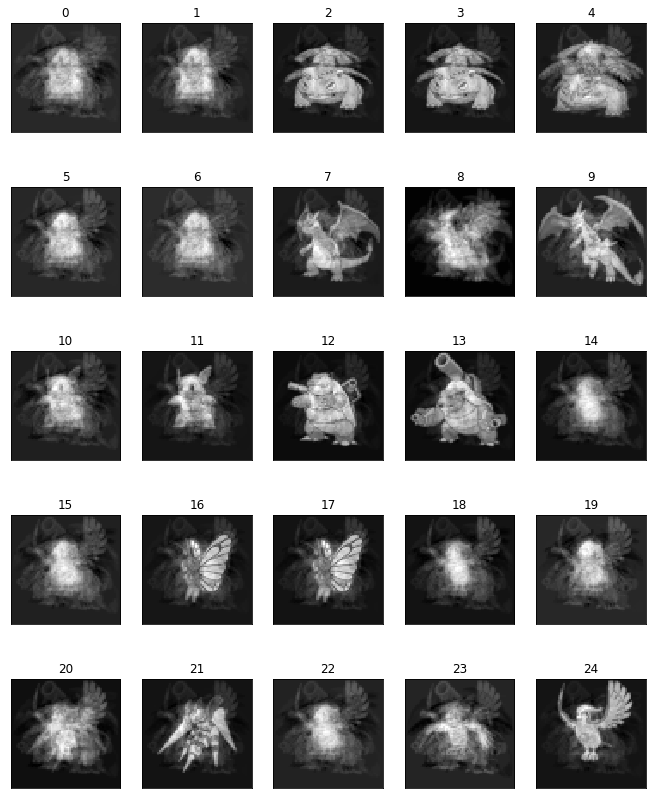

In [22]:
# Compression with 12 principal components
comp_data = PCA_compress(dataset, 12, 30)
plot_gallery(comp_data,
            titles = np.arange(len(comp_data)),
            h = 64, w = 64,
            n_row = 5, n_col = 5)

## Dimensionality Reduction with Autoencoders

Another method of dimensionality reduction is by using an autoencoder. We will be implementing a **stacked undercomplete autoencoder**. We will be working off the neural network implementation from last week, but will make some changes.

We are also going to try to get a much better result than PCA, in particular try to encode the Pokemon into **a subspace of dimension 4**. This means that the bottleneck hidden layer, or *code*, is of length 4. In order to get such good results, we are going to have to use some of the tricks from the lectures, in particular **Xavier Initialisation**, **ReLU activations** and **Mini-batch training**.

We are going to make two explicit network classes, an encoder and a decoder. Each will have 3 fully connected layers, we will be going from 4096 to 512 to 64 and then 4, and vice-versa for the decoder.

The first part we will implement is the FullyConnectedLayer(). The only part we are going to change is the initialisation method, from normally distributed weights with standard deviation 1 to using **Xavier initialisation**. As explained in lectures, this is to help saturation (see follow up question below). In lectures, the standard deviation deviation for Xavier initialisation of normally distributed weights is 
$$\sqrt{\frac{1}{n_{in}}}$$
but we are going to change this to the more commonly used variant (considers making sure the backpropagated signal is also not saturated, see [here](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) for details)

$$\sqrt{\frac{2}{n_{in}+n_{out}}}.$$

Here we have denoted $n_{in}$ as the dimension of the input to the layer, and $n_{out}$ the dimension of the output of the layer.

We will also consider the bias as another input, and thus use the same initialisation (with $n_{in}$ increased by 1).

### Question
What is saturation, and why is it especially important in this network compared to the one we implemented last week?

### <span style="color:blue">Answer</span>
<i>--- replace this with your solution, add and remove code and markdown cells as appropriate ---</i>

In [2]:
class FullyConnectedLayer():
    """
    This is a class skeleton provided.
    It should perform y = Xw + b and its correspongding gradient.
    If you never defined any classes in python before, you probably want to read other tutorials.
    """
    def __init__(self, in_features, out_features):
        """
        This is the init function where you have all the attributes needed defined.
        You don't have to modify any thing in this function but you should read it carefully.
        What each represents will be explained in the next few functions.
        """
        self.in_features = in_features
        self.out_features = out_features
        self.weight = np.zeros((in_features, out_features))
        self.bias = np.zeros((out_features, 1))
        self.g_weight = np.zeros((in_features, out_features))
        self.g_bias = np.zeros((out_features, 1))
        self.input = None

    def init_weights(self):
        """
        Currently, the weight and bias of this layer is initilized to zero, which is terrible.
        You want to re-initilize the weight and bias with Xavier initialisation as explained above.
        After you finish, comment out raise NotImplementedError.
        No return value is needed.
        """
        self.weights = (np.random.standard_normal((self.out_features, self.in_features)) *
                  np.sqrt(2 / (self.out_features + self.in_features)))
        
    def forward_pass(self, X):
        """
        Take the output of last layer as X and return the result.
        Don't forget to save the input X to self.input. You will need the input for gradient calculation.
        After you finish, comment out raise NotImplementedError.
        If you are new to python/numpy, you probably want to figure out what is broadcasting 
        (see http://cs231n.github.io/python-numpy-tutorial/#numpy-broadcasting).
        """

        self.input = X
        
        out = np.dot(X, self.weight) + self.bias.T
      
        return out
        

    def backward_pass(self, g_next_layer):
        """
        g_next_layer is the gradient passed from next layer (the layer after current layer in forward pass).
        You need to calculate 3 things.
        First, the gradient with respect to bias, self.g_bias.
        Second, the gradient with respect to weights, self.g_weight.
        Third, the gradient with respect to last layer (the layer formed by the current weight and bias), g_last_layer.
        Save the gradient with respect to bias and the gradient with respect to weight.
        Return the gradient with respect to last layer.
        """

        self.g_weight = np.dot(self.input.T, g_next_layer)
        self.g_bias = np.sum(g_next_layer, axis=0, keepdims=True)

        g_last_layer = np.dot(g_next_layer, self.weight.T)

        return g_last_layer

    def update(self, learning_rate):
        """
        Update the weight and bias use the gradient that you just calculated.
        No return is needed.
        """
        
        self.weight -= learning_rate*self.g_weight
        self.bias -= learning_rate*self.g_bias.T


In [ ]:
# replace this with your solution, add and remove code and markdown cells as appropriate

Next we are going to implement our activation functions. We already have our Sigmoid layer from last week. We need to use this at the end of our network, as our outputs (the resulting image) needs to be within $[0,1]$. However, for the inner activation functions, we are going to use the **ReLU** function which works better in practice.

### Question
What is the benefit of ReLU as an activation function? What is its gradient?

### <span style="color:blue">Answer</span>
<i>--- replace this with your solution, add and remove code and markdown cells as appropriate ---</i>

In [ ]:
def sigmoid(X):
    """
    Make sure that you function works with X being matrix.
    Use functions in numpy instead of functions in math.
    """
    return 1/(1 + np.exp(-X))
class Sigmoid():
    def __init__(self):
        """
        This is the init function where you have all the attributes needed defined.
        You don't have to modify any thing in this function but you should read it carefully.
        """
        self.input = None

    def forward_pass(self, X):
        """
        Apply sigmoid function to input and save the input for later.
        """
        self.input = X
        return sigmoid(X)

    def backward_pass(self, g_next_layer):
        """
        Calculate the gradient with respect to the input.
        g_next_layer is the gradient passed from next layer (the layer after current layer in forward pass).
        Return the gradient with respect to the output of the last layer.
        """
        g_last_layer = sigmoid(self.input) * ( 1 - sigmoid(self.input)) * g_next_layer

        return g_last_layer

    def update(self, learning_rate):
        """
        There is no parameter to update for this layer, but we still define this function to maintain a uniform interface.
        """
        pass


class ReLU():
    def __init__(self):
        """
        This is the init function where you have all the attributes needed defined.
        You don't have to modify any thing in this function but you should read it carefully.
        """
        self.input = None

    def forward_pass(self, X):
        """
        Apply sigmoid ReLU to input and save the input for later.
        """        
        self.input = np.maximum(np.zeros(X.shape), X)
        return None

    def backward_pass(self, g_next_layer):
        """
        Calculate the gradient with respect to the input.
        g_next_layer is the gradient passed from next layer (the layer after current layer in forward pass).
        Return the gradient with respect to the output of the last layer.
        """
        ###############
        #YOU CODE HERE#
        ###############
        
        g_last_layer = None

        return g_last_layer

    def update(self, learning_rate):
        """
        There is no parameter to update for this layer, but we still define this function to maintain a uniform interface.
        """
        pass

In [ ]:
# replace this with your solution, add and remove code and markdown cells as appropriate

We are also going to change our loss function, as we care about the actual values of the resulting sigmoid output, we are not thresholding anything to classify into classes. Thus we are going to use the Mean Squared Error loss (MSE).

In [ ]:
class MSELoss():
    def __init__(self):
        """
        This is the init function where you have all the attributes needed defined.
        You don't have to modify any thing in this function but you should read it carefully.
        """
        self.input_y = None
        self.input_t = None
        self.input_N = None


    def forward_pass(self, y, t):
        """
        y: batch_size * 1  0 <= y <= 1, the predictions
        t: batch_size * 1 , the targets
        (make sure y and t have the same shape. (N,) and (N,1) are different!)
        
        Save the input y, t and batch size N and calculate the loss.
        Return the mean of the loss (a scalar).
        """
        
        ###############
        #YOU CODE HERE#
        ###############
        
        raise NotImplementedError

        return None
    
    def backward_pass(self, g_next_layer = 1):
        """
        Nomrally, loss layer is the last layer in a neural network. Thus, we set the g_next_layer to 1.
        Calculate the loss of the input y.
        """
        raise NotImplementedError
        
        g_last_layer = None

        return g_last_layer

    def update(self, learning_rate):
        """
        There is no parameter to update for this layer, but we still define this function to maintain a uniform interface.
        """
        pass

Finally we are going to implement the two neural networks, encoder and decoder. To do this, we will extend the Network class, and then just add what we need to ```self.sequential```. Note that we have also added a return value in the backward pass, as we want to pass the gradient from the decoder to the encoder.

The **encoder** should have 3 fully connected layers, going from 4096 to 512 to 64 and then to 4. The activation functions should all be ReLU.

The **decoder** should have 3 fully connected layers, going from 4 to 64 to 512 and then to 4096. The activation functions should all be ReLU, except for the last layer's activation which should be Sigmoid to get the correct range.

If you have time, experiment with changing these. Does changing to Sigmoid reduce performance? Can you get better performance by changing the number of layers and hidden unit sizes?

In [ ]:
class Network():
    def __init__(self):
        self.sequential = []
        
    def forward_pass(self, X):

        for l in self.sequential:

            X = l.forward_pass(X)

        return X

    def backward_pass(self, grad):
        
        for l in reversed(self.sequential):

            grad = l.backward_pass(grad)
        
        return grad
            

    def update(self, learning_rate):

        for l in self.sequential:

            l.update(learning_rate)

class Encoder(Network):
    def __init__(self):
        Network.__init__(self)
        """
        Initialize all layers that you need and append them to the list in the correct order.
        Don't forget to initilize the weights for fully connected layers.
        """
        
        ###############
        #YOU CODE HERE#
        ###############
        
        raise NotImplementedError


class Decoder(Network):
    def __init__(self):
        Network.__init__(self)
        """
        Initialize all layers that you need and append them to the list in the correct order.
        Don't forget to initilize the weights for fully connected layers.
        """
        
        ###############
        #YOU CODE HERE#
        ###############
        
        raise NotImplementedError

In [ ]:
# replace this with your solution, add and remove code and markdown cells as appropriate

We now initialise the classes.

In [ ]:
try:
    np.random.seed(1)
    encoder = Encoder()
    decoder = Decoder()
    mse = MSELoss()
    implemented = True
except NotImplementedError:
    implemented = False
    print('you need to complete the implementation')

### Training the neural network
As we are doing dimensionality reduction, there is no need for a train-test split. We have set some hyper-parameters for you, e.g. epochs, batch_size and learning rate. In particular the batch size is much smaller than the training set size.
### Question
What is the benefit of mini-batch training (training with small batch size, not the whole training set)?

### <span style="color:blue">Answer</span>
<i>--- replace this with your solution, add and remove code and markdown cells as appropriate ---</i>

In [ ]:
if not implemented:
    
    print('you need to complete the implementation')

else:

    training_epoch = 50

    # We have set a mini-batch set size of 30, having found that it works well in practice. Try setting it equal
    # to the size of the traning set and see how well it performs. You may have to change learning rate in this case.
    batch_size = 30
    # batch_size = len(images)

    for i in range(training_epoch):
        # We want to randomise the batches that we get for each epoch
        # Also helps for when the batch size does not divide nicely into the size of the dataset
        random_idxes = np.random.permutation(len(images))
        batches = [images[random_idxes[i*batch_size:(i+1)*batch_size]] for i in range(len(images)//batch_size)]

        loss_vals = []
        for (j, batch) in enumerate(batches):
            """
            This is the main training loop.
            You need to first run a forward pass on the encoder, get a code, then run the decoder on the code to get X_hat.
            Put these into the loss function, calculate the loss and do a back pass.
            Then update the network.
            Append the loss into the list loss_vals so we can see the average loss of each epoch.
            If you have used our hyperparamters, the learning rate we set should work for both the encoder and decoder.
            If you have changed the structure, experiment to see if you can find a good learning rante
            """
            learning_rate = 5e-3
            X = batch


            ###############
            #YOU CODE HERE#
            ###############

            X_hat = X * 0 # you code here

            train_loss = 0 # you code here
            loss_vals.append(train_loss)


        print("Epoch %d: Train_loss %f" %(i+1, np.mean(loss_vals)))
        show_every = 10
        if i % show_every == show_every - 1:
            plot_gallery(X_hat, np.arange(batch_size), 64, 64, min(2, int(np.ceil(batch_size/6))), 5)
            plot_gallery(X, np.arange(batch_size), 64, 64, min(2, int(np.ceil(batch_size/6))), 5)

In [ ]:
# replace this with your solution, add and remove code and markdown cells as appropriate

## Visualising the autoencoder results
Visualise the autoencoder reconstructions for 30 images. Where they what you expect? Compare them to the reconstruction of 15 components. If you have time/are interested, try training for longer and/or the autoencoder with a higher bottleneck dimension.

In [ ]:
# replace this with your solution, add and remove code and markdown cells as appropriate

## Visualising autoencoder features

You can find the features the autoencoder is picking up by decoding a hidden unit vector of the form $(0,\dots,0,1,0,\dots,0)$. How do these features compare to those detected by PCA? Also try visualising scaled versions of the features.

In [ ]:
# replace this with your solution, add and remove code and markdown cells as appropriate

## Autoencoder with linear transition functions

Training an autoencoder with linear transition functions should result in projecting the dataset to the same subspace as in PCA. Check this for 4 principal component.

Do do this, make a new encoder and decoder with bottleneck of dimension 4, and use no activations functions (so you only need to use 1 FullyConnectedLayer per network). Train the network again, and again look at what the basis vectors for the bottleneck dimension return (i.e. repeat the "Visualising autoencoder features" question with this new model).

In [ ]:
# replace this with your solution, add and remove code and markdown cells as appropriate

In [ ]:
# replace this with your solution, add and remove code and markdown cells as appropriate

In [ ]:
# replace this with your solution, add and remove code and markdown cells as appropriate

In [ ]:
# replace this with your solution, add and remove code and markdown cells as appropriate

### <span style="color:blue">Answer</span>
<i>--- replace this with your solution, add and remove code and markdown cells as appropriate ---</i>